In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, log_loss, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
df = pd.read_csv('sample_microfinance_data.csv')
df.head()

,CustomerID,Age,Gender,LoanAmount,PaybackAmount,Income,LoanDuration,PreviousLoans,PaidOnTime
0,1,53,Male,10,12,1451534,8,2,1
1,2,58,Male,10,12,4685116,2,0,0
2,3,47,Male,5,6,3115762,1,0,0
3,4,45,Female,5,6,2758553,5,0,1
4,5,18,Female,10,12,4641911,5,0,0


In [2]:
df.describe()

,CustomerID,Age,LoanAmount,PaybackAmount,Income,LoanDuration,PreviousLoans,PaidOnTime
count,50.00000,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000
mean,25.50000,38.820000,7.500000,9.000000,3.032964e+06,5.300000,1.900000,0.520000
std,14.57738,12.507451,2.525381,3.030458,1.154453e+06,2.597094,1.568178,0.504672
min,1.00000,18.000000,5.000000,6.000000,1.058922e+06,1.000000,0.000000,0.000000
25%,13.25000,30.000000,5.000000,6.000000,2.291591e+06,3.000000,0.000000,0.000000
50%,25.50000,42.500000,7.500000,9.000000,3.082564e+06,5.000000,2.000000,1.000000
75%,37.75000,48.750000,10.000000,12.000000,3.880020e+06,8.000000,3.000000,1.000000
max,50.00000,58.000000,10.000000,12.000000,4.814879e+06,9.000000,4.000000,1.000000


In [3]:
df.isnull().sum()

CustomerID       0
Age              0
Gender           0
LoanAmount       0
PaybackAmount    0
Income           0
LoanDuration     0
PreviousLoans    0
PaidOnTime       0
dtype: int64

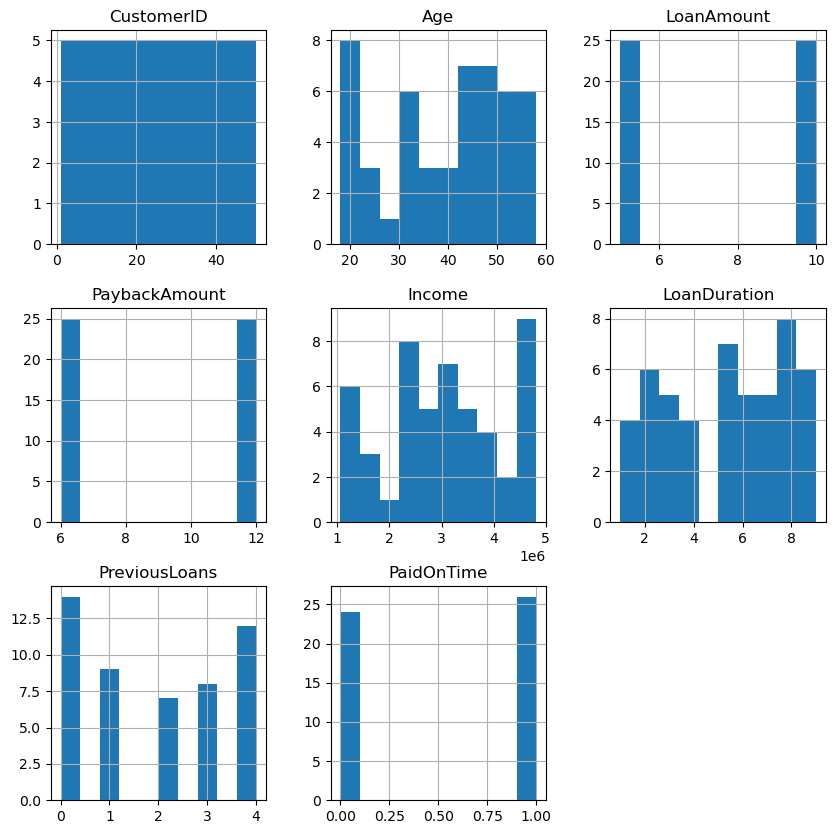

<Figure size 1200x800 with 0 Axes>

In [5]:
df.hist(figsize=(10, 10))
plt.show()
plt.figure(figsize=(12, 8))
plt.show()

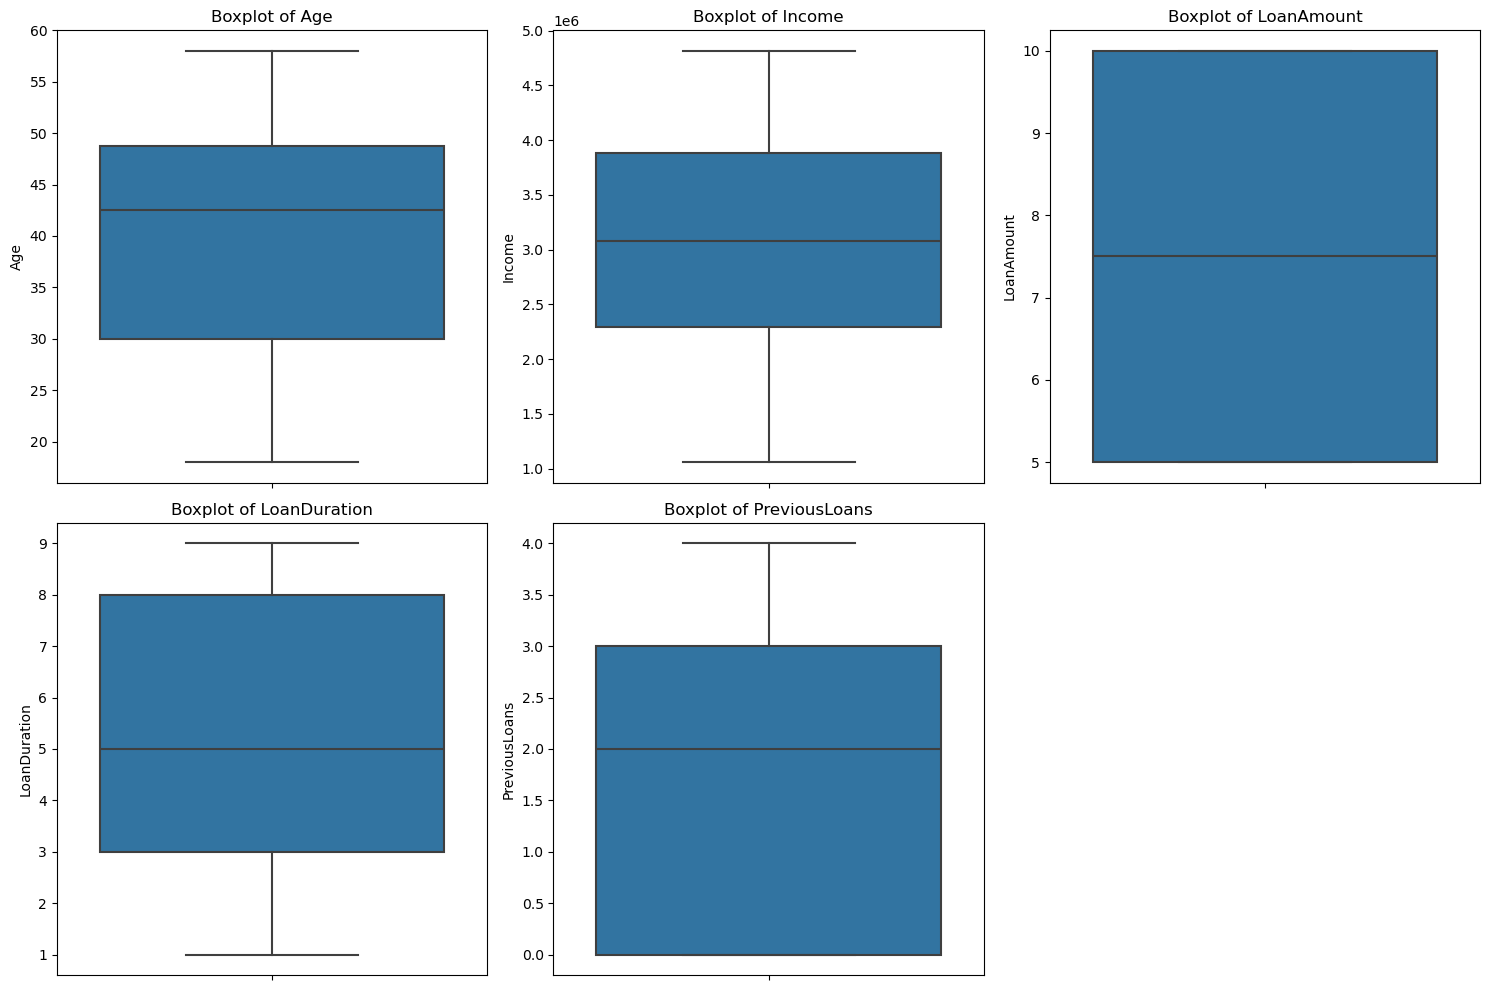

In [9]:
numerical_features = ['Age', 'Income', 'LoanAmount', 'LoanDuration', 'PreviousLoans']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

In [12]:
def detect_outliers(df, features):
    outliers = {}
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[feature] = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
    return outliers
outliers = detect_outliers(df, numerical_features)
def remove_outliers(df, outliers):
    for feature, indices in outliers.items():
        df = df.drop(indices)
    return df

df_clean = remove_outliers(df, outliers)

In [13]:
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])

In [14]:
X = df.drop(columns=['CustomerID', 'PaidOnTime'])
y = df['PaidOnTime']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train[['Age', 'Income', 'LoanDuration', 'PreviousLoans']] = scaler.fit_transform(X_train[['Age', 'Income', 'LoanDuration', 'PreviousLoans']])
X_test[['Age', 'Income', 'LoanDuration', 'PreviousLoans']] = scaler.transform(X_test[['Age', 'Income', 'LoanDuration', 'PreviousLoans']])

In [15]:
df['LoanToIncomeRatio'] = df['LoanAmount'] / df['Income']
def categorize_age(age):
    if age < 25:
        return 'Young'
    elif age < 50:
        return 'Middle-aged'
    else:
        return 'Senior'

df['AgeGroup'] = df['Age'].apply(categorize_age)
def categorize_loan_duration(duration):
    if duration <= 3:
        return 'Short-term'
    elif duration <= 7:
        return 'Medium-term'
    else:
        return 'Long-term'

df['LoanDurationCategory'] = df['LoanDuration'].apply(categorize_loan_duration)
df['AgeGroup'] = label_encoder.fit_transform(df['AgeGroup'])
df['LoanDurationCategory'] = label_encoder.fit_transform(df['LoanDurationCategory'])
df.head()


,CustomerID,Age,Gender,LoanAmount,PaybackAmount,Income,LoanDuration,PreviousLoans,PaidOnTime,LoanToIncomeRatio,AgeGroup,LoanDurationCategory
0,1,53,1,10,12,1451534,8,2,1,0.000007,1,0
1,2,58,1,10,12,4685116,2,0,0,0.000002,1,2
2,3,47,1,5,6,3115762,1,0,0,0.000002,0,2
3,4,45,0,5,6,2758553,5,0,1,0.000002,0,1
4,5,18,0,10,12,4641911,5,0,0,0.000002,2,1


In [16]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

print("Model: Logistic Regression")
print(classification_report(y_test, y_pred))
print(f"Log Loss: {log_loss(y_test, y_pred_proba)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print("-" * 50)

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.57      0.67      0.62         6

    accuracy                           0.50        10
   macro avg       0.45      0.46      0.45        10
weighted avg       0.48      0.50      0.48        10

Log Loss: 0.7730183500359301
Precision: 0.5714285714285714
Recall: 0.6666666666666666
--------------------------------------------------


In [17]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, y_train)
y_pred = dec_tree.predict(X_test)
y_pred_proba = dec_tree.predict_proba(X_test)[:, 1]

print("Model: Decision Tree")
print(classification_report(y_test, y_pred))
print(f"Log Loss: {log_loss(y_test, y_pred_proba)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print("-" * 50)


Model: Decision Tree
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.83      0.91         6

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10

Log Loss: 3.604365338911715
Precision: 1.0
Recall: 0.8333333333333334
--------------------------------------------------


In [18]:
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train)
y_pred = rand_forest.predict(X_test)
y_pred_proba = rand_forest.predict_proba(X_test)[:, 1]

print("Model: Random Forest")
print(classification_report(y_test, y_pred))
print(f"Log Loss: {log_loss(y_test, y_pred_proba)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print("-" * 50)

Model: Random Forest
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.80      0.67      0.73         6

    accuracy                           0.70        10
   macro avg       0.70      0.71      0.70        10
weighted avg       0.72      0.70      0.70        10

Log Loss: 0.5239190635943523
Precision: 0.8
Recall: 0.6666666666666666
--------------------------------------------------


In [20]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
y_pred_proba = knn_model.predict_proba(X_test)[:, 1]

print("Model: K-Nearest Neighbors")
print(classification_report(y_test, y_pred))
print(f"Log Loss: {log_loss(y_test, y_pred_proba)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print("-" * 50)

Model: K-Nearest Neighbors
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.75      1.00      0.86         6

    accuracy                           0.80        10
   macro avg       0.88      0.75      0.76        10
weighted avg       0.85      0.80      0.78        10

Log Loss: 0.4768458164069112
Precision: 0.75
Recall: 1.0
--------------------------------------------------


In [22]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
y_pred_proba = nb_model.predict_proba(X_test)[:, 1]

print("Model: Naive Bayes")
print(classification_report(y_test, y_pred))
print(f"Log Loss: {log_loss(y_test, y_pred_proba)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print("-" * 50)

Model: Naive Bayes
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.75      0.50      0.60         6

    accuracy                           0.60        10
   macro avg       0.62      0.62      0.60        10
weighted avg       0.65      0.60      0.60        10

Log Loss: 0.7759472620752776
Precision: 0.75
Recall: 0.5
--------------------------------------------------


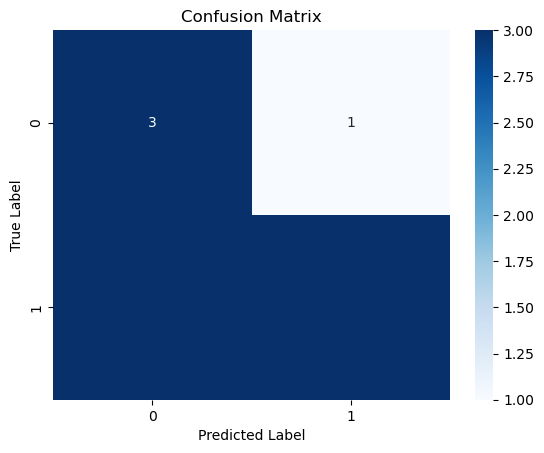

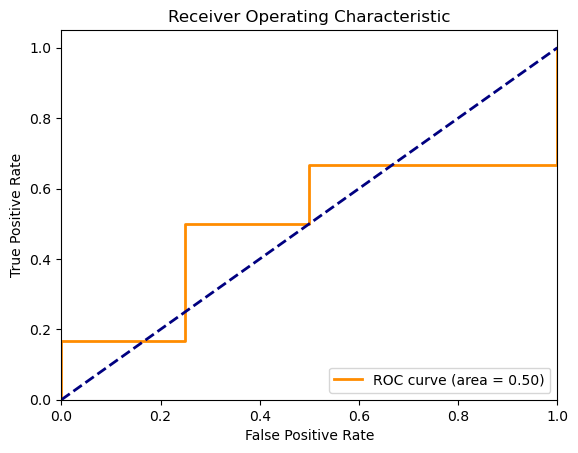

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

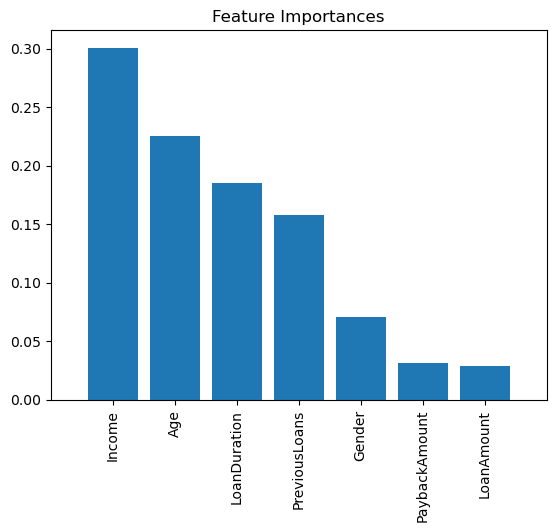

In [30]:
importances = rand_forest.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()